Epoch 0, Loss: 0.001998241525143385
Epoch 25, Loss: 2.6977722882293165e-05
Epoch 50, Loss: 0.0008212008397094905
Epoch 75, Loss: 4.961146260029636e-05
Epoch 100, Loss: 0.00531563488766551
Epoch 125, Loss: 0.0005787264090031385
Final loss: 0.00038086692802608013


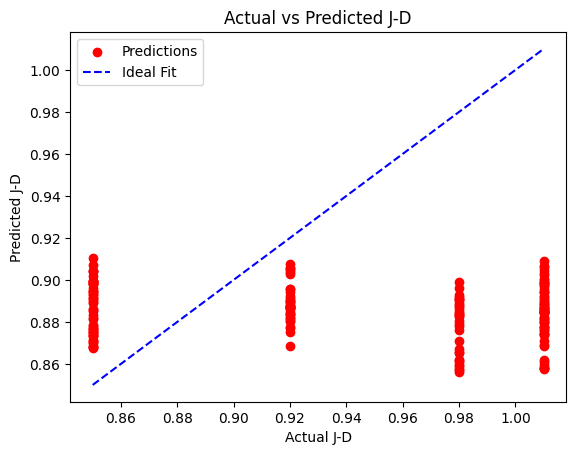

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import random

# Load datasets
glb_data = pd.read_csv('GLB.Ts+dSST.csv', header=1)  # GLB.Ts+dSST
sea_level_data = pd.read_csv('sealevel.csv')         # Sea Level dataset

# Clean the GLB dataset
glb_data.replace('***', np.nan, inplace=True)
glb_data.dropna(inplace=True)

# Filter data from 1993 onwards
glb_data = glb_data[(glb_data['Year'] >= 1993) & (glb_data['Year'] <= 2021)]
sea_level_data = sea_level_data[(sea_level_data['Year'] >= 1993) & (sea_level_data['Year'] <= 2021)]

# Ensure the 'Year' column is integer type for both datasets
glb_data['Year'] = glb_data['Year'].astype(int)
sea_level_data['Year'] = sea_level_data['Year'].astype(int)

# Merge the datasets by matching GMSL_GIA with 'J-D' based on the 'Year' column
paired_data = pd.merge(sea_level_data[['Year', 'GMSL_GIA']], glb_data[['Year', 'J-D']], on='Year')

# Drop duplicate 'J-D' values for the same 'GMSL_GIA', selecting just one if there are duplicates
paired_data = paired_data.drop_duplicates(subset=['GMSL_GIA'])

# Normalize the data (GMSL_GIA and 'J-D')
scaler = MinMaxScaler(feature_range=(-1, 1))
normalized_data = scaler.fit_transform(paired_data[['GMSL_GIA', 'J-D']])

# Split into training (80%) and testing (20%)
train_size = int(len(normalized_data) * 0.8)
train_data = normalized_data[:train_size]
test_data = normalized_data[train_size:]

# Prepare the input-output sequences for LSTM (predict 'J-D' from GMSL_GIA)
def create_inout_sequences(input_data, window_size):
    inout_seq = []
    L = len(input_data)
    for i in range(L - window_size):
        train_seq = input_data[i:i + window_size, 0]  # GMSL_GIA (column 0) as input
        train_label = input_data[i + window_size, 1]  # 'J-D' (column 1) as the target
        inout_seq.append((torch.FloatTensor(train_seq).view(-1, 1), torch.FloatTensor([train_label])))
    return inout_seq

window_size = 12
train_inout_seq = create_inout_sequences(train_data, window_size)

# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

# Instantiate model, loss function, and optimizer
model = LSTM()
loss_function = nn.MSELoss()  # Mean Squared Error Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 150
for epoch in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if epoch % 25 == 0:
        print(f'Epoch {epoch}, Loss: {single_loss.item()}')

print(f'Final loss: {single_loss.item()}')

# Testing and predicting for the test set
model.eval()

# Ensure we have enough data for the test phase
if len(test_data) > window_size:
    test_inputs = torch.FloatTensor(test_data[:, 0]).view(-1, 1)  # Using GMSL_GIA for prediction
    predictions = []

    with torch.no_grad():
        for i in range(len(test_inputs) - window_size):
            seq = test_inputs[i:i + window_size]
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                 torch.zeros(1, 1, model.hidden_layer_size))
            predictions.append(model(seq).item())

    # Inverse transform the predicted and actual 'J-D' values to their original scale
    test_actual = scaler.inverse_transform(test_data[window_size:, :])[:, 1]  # Actual 'J-D' from test data
    predictions_with_gmsl = np.column_stack((np.zeros(len(predictions)), np.array(predictions)))
    predictions_inverse = scaler.inverse_transform(predictions_with_gmsl)[:, 1]  # Predicted 'J-D'

    # Save actual vs predicted 'J-D' values to a CSV file
    actual_vs_predicted_df = pd.DataFrame({
        'Actual J-D': test_actual,
        'Predicted J-D': predictions_inverse
    })
    actual_vs_predicted_df.to_csv('actual_vs_predicted_jd.csv', index=False)

    # Scatter plot: Actual 'J-D' vs Predicted 'J-D'
    plt.scatter(test_actual, predictions_inverse, label="Predictions", color='red')
    plt.plot([min(test_actual), max(test_actual)], [min(test_actual), max(test_actual)], color='blue', linestyle='--', label="Ideal Fit")
    plt.xlabel('Actual J-D')
    plt.ylabel('Predicted J-D')
    # Add labels like 1, 2, 3, ... on both axes
    # You can customize these based on your actual data range
    max_value = max(max(test_actual), max(predictions_inverse))  # Get the maximum value for scaling
    ticks = np.arange(1, int(max_value) + 2, 1)  # Generate tick values starting from 1

    plt.xticks(ticks)  # Set x-axis ticks
    plt.yticks(ticks)  # Set y-axis ticks
    plt.legend()
    plt.title('Actual vs Predicted J-D')
    plt.show()

else:
    print("Not enough test data after applying window_size. Try reducing the window size or increasing test data.")
